## Run_QLC_FT

This code solves the QLC problem in Fourier space. Parameters include:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time
from scipy.fft import fft, ifft, rfft, irfft, fftfreq

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [2]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

In [3]:
# This cell contains duplicates of what's in QLCstuff.py, but with the ability to deactivate some terms
# for comparison with the FT version. Note that the version in QLCstuff.py doesn't have the prefix "QLC."

def run_f1d(\
           NQLL_init_1D,Ntot_init_1D,times,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI,\
           AssignQuantity,\
           verbose=0, odemethod='LSODA'):

    """ Solves the QLC-2 problem, with units """

    # Prep for the integration
    nt = len(times)
    nx = len(NQLL_init_1D)
    ylast = np.array([NQLL_init_1D,Ntot_init_1D])
    ylast = np.reshape(ylast,2*nx)
    ykeep_1D = [ylast]
    lastprogress = 0
    sigmaI_mag = sigmaI.magnitude
    t1 = time()
    
    # This is to get j2_list because it's more efficient to pre-calculate it
    bj_list = rfft(NQLL_init_1D)
    j_list = np.array([j for j in range(len(bj_list))])
    j2_list = np.array(j_list)**2

    # Bundle parameters for ODE solver
    scalar_params = np.array(\
            [Nbar, Nstar, sigma0.magnitude, nu_kin_mlyperus.magnitude, Doverdeltax2.magnitude, tau_eq.magnitude])

    # Loop over times
    for i in range(0,nt-1):
                
        # Specify the time interval of this step
        tinterval = [times[i].magnitude,times[i+1].magnitude]
        
        # Integrate up to next time step
        sol = solve_ivp(\
            f1d_solve_ivp, tinterval, ylast, args=(scalar_params, sigmaI_mag, j2_list), \
            rtol=1e-12, method=odemethod) 
        ylast = sol.y[:,-1]
        
        # Stuff into keeper arrays
        ykeep_1D.append(ylast)
        
        # Progress reporting
        progress = int(i/nt*100)
        if np.mod(progress,10) == 0:
            if progress > lastprogress:
                t2 = time()
                elapsed = (t2 - t1)/60
                print(progress,'%'+' elapsed time is %.3f minutes' %elapsed)
                lastprogress = progress

    print('100% done')
    print('status = ', sol.status)
    print('message = ', sol.message)
    print(dir(sol))
    
    ykeep_1D = np.array(ykeep_1D, np.float64)
    ykeep_1Darr = np.array(ykeep_1D, np.float64)
    ykeep_1Darr_reshaped = np.reshape(ykeep_1Darr,(nt,2,nx))
    Ntotkeep_1D = ykeep_1Darr_reshaped[:,1,:]
    NQLLkeep_1D = ykeep_1Darr_reshaped[:,0,:]
    
    return Ntotkeep_1D, NQLLkeep_1D

def f1d_solve_ivp(t, y, scalar_params, sigmaI, j2_list):
    Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverdeltaX2, tau_eq = scalar_params
    l = int(len(y)/2)
    NQLL0 = y[:l]
    Ntot0 = y[l:]
    
    # Ntot deposition
    m = (NQLL0 - (Nbar - Nstar))/(2*Nstar)
    sigma_m = (sigmaI - m * sigma0)
    dNtot_dt = nu_kin_mlyperus * sigma_m

    # Diffusion term based on FT
    Dcoefficient1 = 4*DoverdeltaX2/l**2*np.pi**2; #print('Dcoefficient1', Dcoefficient1)
    bj_list = rfft(NQLL0)
    cj_list = bj_list*j2_list
    dy = -Dcoefficient1  * irfft(cj_list)

    # Combined
    dNtot_dt += dy

    # NQLL    
    dNQLL_dt = dNtot_dt - QLC.getDeltaNQLL(Ntot0,Nstar,Nbar,NQLL0)/tau_eq
    
    # Package for output
    derivs = np.empty(2*l)
    derivs[:l] = dNQLL_dt
    derivs[l:] = dNtot_dt

    return derivs

### Getting parameters for this run

In [4]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.23 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [5]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

### Varibles that depend on the above

In [6]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Runtime parameters from the namelist 

In [95]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)
print('NQLL_init_1D', NQLL_init_1D)
NQLL_init_1D[50]=2
print('NQLL_init_1D', NQLL_init_1D)

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 50 millisecond
NQLL_init_1D [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

### Run the scenario in Cartesian space (invoking the local version of run_f1d here)

10 % elapsed time is 0.007 minutes
20 % elapsed time is 0.012 minutes
30 % elapsed time is 0.017 minutes
40 % elapsed time is 0.022 minutes
50 % elapsed time is 0.028 minutes
60 % elapsed time is 0.033 minutes
70 % elapsed time is 0.038 minutes
80 % elapsed time is 0.044 minutes
90 % elapsed time is 0.049 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


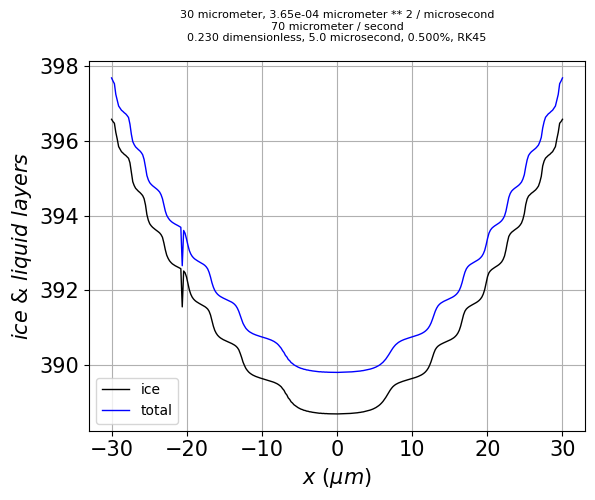

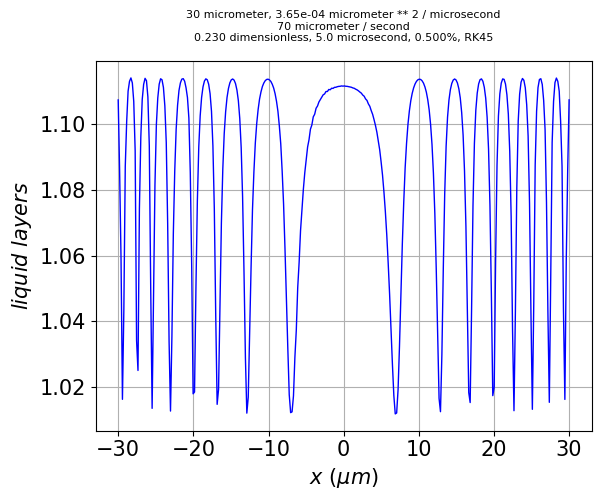

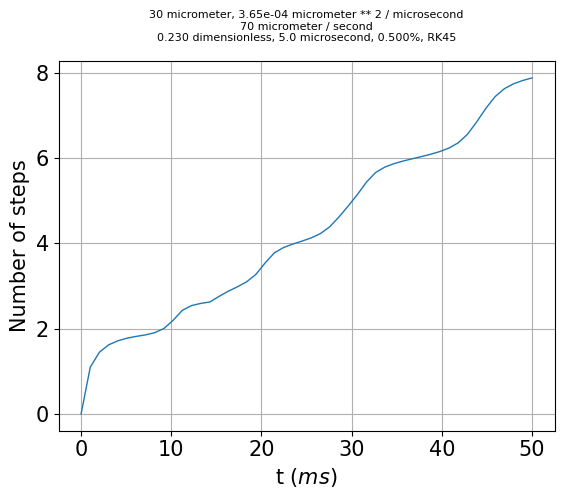

In [96]:
Ntotkeep_1D, NQLLkeep_1D = run_f1d(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Reporting and graphing
# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r.to('percent').magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

### Run the scenario in FT space for comparison

In [99]:
# This is our sandbox for developing a FT equivalent of run_f1d

def run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,times,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2, tau_eq, sigmaI,\
           AssignQuantity,\
           verbose=0, odemethod='RK45'):

    """ Solves the QLC problem, with units, in Fourier space """

    # Prep for the integration
    nt = len(times)
    lastprogress = 0
    sigmaI_mag = sigmaI.magnitude
    t1 = time()
    
    # This is to get j2_list because it's more efficient to pre-calculate it (but we'll use bj_list too)
    bj_list = rfft(NQLL_init_1D)
    n_list = len(bj_list)
    j_list = np.array([j for j in range(n_list)])
    j2_list = np.array(j_list)**2

    # Bundle parameters for ODE solver
    scalar_params = np.array([Nbar, Nstar, sigma0.magnitude, nu_kin_mlyperus.magnitude, DoverL2.magnitude, tau_eq.magnitude])

    # This is packaging up the dynamical variables as FT 
#     aj_list = rfft(Ntot_init_1D)
#     Ylast = np.array([bj_list,aj_list])
#     Ylast = np.reshape(Ylast,2*n_list)
#     Ykeep_1D = [Ylast]
    Ylast = np.array(bj_list)
    Ykeep_1D = [Ylast]
        
    # This is getting the imposed supersaturation as FT
    SigmaI_mag = rfft(sigmaI_mag)
    SigmaI_mag = np.real(SigmaI_mag)
    
    # Loop over times
    for i in range(0,nt-1):
                
        # Specify the time interval of this step
        tinterval = [times[i].magnitude,times[i+1].magnitude]
        
        # Integrate up to next time step
        sol = solve_ivp(\
            f1d_solve_ivp_FT, tinterval, Ylast, args=(scalar_params, SigmaI_mag, j2_list), \
            rtol=1e-12, method=odemethod) 
        Ylast = sol.y[:,-1]
#         print('sol.y',sol.y)
#         print('Ylast',Ylast)
        
        # Stuff into keeper arrays
        Ykeep_1D.append(Ylast)
        
        # Progress reporting
        progress = int(i/nt*100)
        if np.mod(progress,10) == 0:
            if progress > lastprogress:
                t2 = time()
                elapsed = (t2 - t1)/60
                print(progress,'%'+' elapsed time is %.3f minutes' %elapsed)
                lastprogress = progress

    print('100% done')
    print('status = ', sol.status)
    print('message = ', sol.message)
    print(dir(sol))
    
#     ykeep_1D = np.array(ykeep_1D, np.float64)
#     ykeep_1Darr = np.array(ykeep_1D, np.float64)
#     ykeep_1Darr_reshaped = np.reshape(ykeep_1Darr,(nt,2,nx))
#     Ntotkeep_1D = ykeep_1Darr_reshaped[:,1,:]
#     NQLLkeep_1D = ykeep_1Darr_reshaped[:,0,:]
    
#     return Ntotkeep_1D, NQLLkeep_1D


    NQLL_final = irfft(sol.y[:,-1])
    return 0, NQLL_final


def f1d_solve_ivp_FT(t, Y, scalar_params, sigmaI, j2_list):
    Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2, tau_eq = scalar_params
#     l = int(len(Y)/2)
    l = len(Y)
    bj_list = Y[:l]
#     aj_list = Y[l:]
    Dcoefficient1 = DoverL2*np.pi**2
    cj_list = bj_list*j2_list
#     daj_list_dt = -Dcoefficient1 * cj_list
#     dbj_list_dt = daj_list_dt
    dbj_list_dt = -Dcoefficient1 * cj_list

#     derivs = np.empty(2*l)
#     derivs[:l] = dbj_list_dt
#     derivs[l:] = daj_list_dt
#     derivs = np.empty(l)
#     derivs[:l] = dbj_list_dt
    return dbj_list_dt

In [100]:
DoverL2 = D/L**2
Ntotkeep_1D, NQLLkeep_1D = run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

10 % elapsed time is 0.001 minutes
20 % elapsed time is 0.001 minutes
30 % elapsed time is 0.001 minutes
40 % elapsed time is 0.001 minutes
50 % elapsed time is 0.002 minutes
60 % elapsed time is 0.002 minutes
70 % elapsed time is 0.002 minutes
80 % elapsed time is 0.002 minutes
90 % elapsed time is 0.002 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


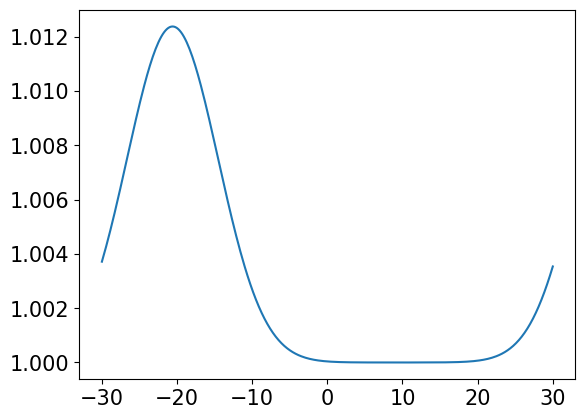

In [102]:
plt.figure()
plt.plot(x_QLC,NQLLkeep_1D)